# Importing necesarry libraries

In [1]:
!pip install -q /lib/wheels/tensorflow-2.9.1-cp38-cp38-linux_x86_64.whl
!pip install -q tensorflow-addons==0.18.0
!pip install -q tensorflow-probability==0.17.0
!pip install -q opencv-python-headless
!pip install -q seaborn

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.11.0 requires tensorflow<2.12,>=2.11.0; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.9.1 which is incompatible.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install -q keras-cv-attention-models
!pip install -qU wandb
!pip install -qU scikit-learn

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
elegy 0.8.6 requires wandb<0.13.0,>=0.12.10, but you have wandb 0.13.9 which is incompatible.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


# Importing libraries

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # to avoid too many logging messages
import pandas as pd, numpy as np, random, shutil
import tensorflow as tf, re, math
import tensorflow.keras.backend as K
import sklearn
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import wandb
import yaml

from IPython import display as ipd
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, StratifiedGroupKFold
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

[percpu.cc : 560] RAW: rseq syscall failed with errno 1
[percpu.cc : 552] RAW: rseq syscall failed with errno 1


# Importing the `train.csv` file

In [4]:
train_df = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/train.csv")
train_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


# Version Check

In [5]:
print('np:', np.__version__)
print('pd:', pd.__version__)
print('sklearn:', sklearn.__version__)
print('tf:',tf.__version__)
print('tfp:', tfp.__version__)
print('tfa:', tfa.__version__)
print('w&b:', wandb.__version__)

np: 1.24.1
pd: 1.5.2
sklearn: 1.2.0
tf: 2.9.1
tfp: 0.17.0
tfa: 0.18.0
w&b: 0.13.9


# Setting up the WANDB login
Weights & Biases (W&B) is MLOps platform for tracking our experiemnts.

In [6]:
# wandb.login()

In [7]:
# wandb.init(project='Kaggle_RSNA_Mammography_cancer_detection_DDSM_model_V1.0')

In [8]:
class CFG:
    # use verbose=0 for silent, vebose=1 for interactive,
    verbose      = 1
    display_plot = True
    
    # device
    device = "TPU-VM" # TPU-VM, GPU
    
    # name of the EfficientNetB4 CNN model
    model_name = 'EfficientNetV1B4'
    
    # number of folds for data-split
    folds = 5
    
    # which folds to train
    selected_folds = [0, 1, 2]

    # size of the image
    img_size = [1024, 512]
    
    # batch_size and epochs]
    batch_size = 28
    epochs = 8
    
    # upsample
    upsample = 10
    
    # seed for data-split, layer init, augs
    seed = 42

    # loss
    loss      = 'BCE'  # BCE, Focal
    use_cw    = False  # use class weight or not
    
    # optimizer
    optimizer = 'Adam'

    # augmentation
    augment   = True
    
        
    # pixel augumentation
    pixel_aug = 0.75  # prob of pixel_aug
    sat  = [0.7, 1.3]
    cont = [0.8, 1.2]
    bri  = 0.05
    hue  = 0.05
    clip = False
    
    # flip
    hflip = True
    vflip = True
    
    # shear 
    prob_translate = 0.5
    pixel_xtranslate = 100
    pixel_ytranslate = 200
    
    # solarize image
    prob_solarize = 0.0
    solarize_thrs = 0.75

    # dropout
    prob_dropout   = 0.75
    num_dropout = 4
    drop_size = 0.05
    
    
    # learning rate
    learning_rate = 1e-6

    # lr-scheduler
    scheduler   = 'exp' # cosine
    
    T_max = 20
    
    # minimum learning rate
    min_lr = 1e-6
    
    # maximum learning rate
    lr_max = 1e-6    
    
    
    # Focal loss parameter
    ALPHA = 0.8 
    GAMMA = 2
    
    # target column
    target_col  = ['cancer']

# Adding the image destination column
The column `image_destination` stores the destination of the stored training images

In [9]:
train_df["image_destination"] = "/kaggle/input/rsna-breast-cancer-detection-poi-images/bc_1280_train_lut/bc_1280_train_lut/" + \
train_df["patient_id"].astype(str) + "_" + train_df["image_id"].astype(str) + ".png"
train_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,image_destination
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection-poi...
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection-poi...
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection-poi...
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection-poi...
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/rsna-breast-cancer-detection-poi...


# Data Split using Stratified Group K Fold
* Data is splited while stratifying, *'laterality', 'view', 'age','cancer', 'biopsy', 'invasive', 'BIRADS', 'implant', 'density','machine_id', 'difficult_negative_case','cancer'*.
* To avoid leakage, data is also split keeping images from same patient in either train or valid not in both.
* StratifiedGroupKFold does the both job stratifying and group split.

In [10]:
num_bins = 5
train_df["age_bin"] = pd.cut(train_df['age'].values.reshape(-1), \
                             bins=num_bins, \
                             labels=False)
train_df["age_bin"].unique()

array([ 2.,  3.,  1.,  0.,  4., nan])

In [11]:
strat_cols = ['laterality', 'view', 'biopsy','invasive', 'BIRADS', \
              'age_bin', \
              'implant', 'density','machine_id', \
              'difficult_negative_case', \
              'cancer']

train_df['stratify'] = ''
for col in strat_cols:
    train_df['stratify'] += train_df[col].astype(str)

skf = StratifiedGroupKFold(n_splits=CFG.folds, shuffle=True)
for fold, (train_idx, val_idx) \
in enumerate(skf.split(train_df, \
                       train_df['stratify'], \
                       train_df["patient_id"])):
    train_df.loc[val_idx, 'fold'] = fold
display(train_df.groupby(['fold', "cancer"]).size())

/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:909: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


fold  cancer
0.0   0         10775
      1           205
1.0   0         10642
      1           251
2.0   0         10647
      1           219
3.0   0         10690
      1           238
4.0   0         10794
      1           245
dtype: int64

In [12]:
train_df['fold'] = train_df['fold'].astype(int)
train_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,image_destination,age_bin,stratify,fold
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection-poi...,2.0,LCC00nan2.00nan29False0,3
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection-poi...,2.0,LMLO00nan2.00nan29False0,3
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection-poi...,2.0,RMLO00nan2.00nan29False0,3
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection-poi...,2.0,RCC00nan2.00nan29False0,3
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/rsna-breast-cancer-detection-poi...,2.0,LCC000.02.00nan21True0,3


# Function for the WANDB library

In [13]:
def wandb_log(**kwargs):
    for k, v in kwargs.items():
        wandb.log({k: v})

In [14]:
# # Max pixel value
# max_pixel_val = 0
# for idx in train_df.index.tolist():
#     pixel_val = np.amax(cv2.imread(train_df.loc[idx, "image_destination"]))
#     train_df.loc[idx, "max_pixel"] = pixel_val
#     if pixel_val > max_pixel_val:
#         max_pixel_val = pixel_val
# print(max_pixel_val)

In [15]:
train_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,image_destination,age_bin,stratify,fold
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection-poi...,2.0,LCC00nan2.00nan29False0,3
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection-poi...,2.0,LMLO00nan2.00nan29False0,3
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection-poi...,2.0,RMLO00nan2.00nan29False0,3
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection-poi...,2.0,RCC00nan2.00nan29False0,3
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/rsna-breast-cancer-detection-poi...,2.0,LCC000.02.00nan21True0,3


In [16]:
def seeding(SEED):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
#     os.environ['TF_CUDNN_DETERMINISTIC'] = str(SEED)
    tf.random.set_seed(SEED)
    print('seeding done!!!')
seeding(CFG.seed)

seeding done!!!


# Configuring the device for training
*  `tf.distribute.cluster_resolver.TPUClusterResolver`: This is an implementation of cluster resolvers for the Google Cloud TPU service. As Cloud TPUs are in alpha, you will need to specify a API definition file for this to consume, in addition to a list of Cloud TPUs in your Google Cloud Platform project. The args **tpu** takes string value corresponding to the TPU to use. It can be the TPU name or TPU worker gRPC address. If not set, it will try automatically resolve the TPU address on Cloud TPUs. If set to "local", it will assume that the TPU is directly connected to the VM instead of over the network.
* `tf.distribute.TPUStrategy`: Synchronous training on TPUs and TPU Pods. TPUs were designed to be scaled out to a TPU Pod. A TPU Pod is a collection of TPU devices connected by dedicated high-speed network interfaces. A TPU Pod allows you to distribute the processing load across multiple TPUs. Each TPU board is connected to a high-performance CPU-based host machine for things like loading and preprocessing data. To take full advantage of larger numbers of TPUs, you must tune several training task parameters.
* `tf.distribute.MirroredStrategy`: Synchronous training across multiple replicas on one machine.
* `tf.distribute.get_strategy`: Returns the current tf.distribute.Strategy object.

In [17]:
if "TPU" in CFG.device:
    tpu = 'local' if CFG.device=='TPU-VM' else None
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu=tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
    except:
        CFG.device = "GPU"
        
if CFG.device == "GPU"  or CFG.device=="CPU":
    ngpu = len(tf.config.experimental.list_physical_devices('GPU'))
    if ngpu>1:
        print("Using multi GPU")
        strategy = tf.distribute.MirroredStrategy()
    elif ngpu==1:
        print("Using single GPU")
        strategy = tf.distribute.get_strategy()
    else:
        print("Using CPU")
        strategy = tf.distribute.get_strategy()
        CFG.device = "CPU"

if CFG.device == "GPU":
    print("Num GPUs Available: ", ngpu)
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/tas

In [18]:
BASE_PATH = '/kaggle/input/rsna-bcd-roi-1024x512-png-v2-dataset'

if CFG.device=="TPU":
    from kaggle_datasets import KaggleDatasets
    GCS_PATH = KaggleDatasets().get_gcs_path(BASE_PATH.split('/')[-1])

# Creating a custom dataset
* `tf.data.Dataset.from_tensor_slices()`: With the help of `tf.data.Dataset.from_tensor_slices()` method, we can get the slices of an array in the form of objects by using this method. For more info click [here](https://www.geeksforgeeks.org/tensorflow-tf-data-dataset-from_tensor_slices/).
* `tf.data.Dataset.map()`: TensorFlow `map()` method of `tf.data.Dataset` used for transforming items in a dataset, refer below snippet for `map()` use. For more info click [here](https://www.gcptutorials.com/article/how-to-use-map-function-with-tensorflow-datasets).
* `.prefetch()`: Creates a Dataset that prefetches elements from this dataset.

In [19]:
import tensorflow_addons.image as tfa_image

def transform_fn(path, target=None, target_size=CFG.img_size, ext='png'):
    """
    Reading png or jpeg files from the folders, and converting it to TF 3D tensor
    """
    file_bytes = tf.io.read_file(path)
    if ext == 'png':
        img = tf.image.decode_png(file_bytes, channels=3)
    elif ext in ['jpg', 'jpeg']:
        img = tf.image.decode_jpeg(file_bytes, channels=3)
    else:
        raise ValueError("Image extension not supported")
    
    # Resizing the image
    img = tf.image.resize(img, target_size, method='bilinear')
    img = tf.cast(img, tf.float32)/255.0
    img = tf.reshape(img, [*target_size, 3])
    
    if target is not None:
        return img, tf.cast(target, tf.float32)
    else:
        return img


def random_float(shape=[], minval=0.0, maxval=1.0):
    rnd = tf.random.uniform(
        shape=shape, minval=minval, maxval=maxval, dtype=tf.float32)
    return rnd
    

def solarize_add(image, target=None, threshold=128):    
    # For each pixel in the image, select the pixel
    # if the value is less than the threshold.
    # Otherwise, subtract 255 from the pixel.
    if target is not None:
        return tf.where(image < threshold, image, 255 - image),  tf.cast(target, tf.float32)
    else:
        return tf.where(image < threshold, image, 255 - image)


def dropout(image, target = None, DIM=CFG.img_size, \
            PROBABILITY = CFG.prob_dropout, CT = CFG.num_dropout, SZ = 0.1):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image with CT squares of side size SZ*DIM removed
    
    # DO DROPOUT WITH PROBABILITY DEFINED ABOVE
    P = tf.cast( tf.random.uniform([],0,1)<PROBABILITY, tf.int32)
    if (P==0)|(CT==0)|(SZ==0): 
        if target is not None:
            return image, tf.cast(target, tf.float32)
        else:
            return image
    
    for k in range(CT):
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM[1]),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM[0]),tf.int32)
        # COMPUTE SQUARE 
        WIDTH = tf.cast( SZ*min(DIM),tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM[0],y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM[1],x+WIDTH//2)
        # DROPOUT IMAGE
        one = image[ya:yb,0:xa,:]
        two = tf.zeros([yb-ya,xb-xa,3], dtype = image.dtype) 
        three = image[ya:yb,xb:DIM[1],:]
        middle = tf.concat([one,two,three],axis=1)
        image = tf.concat([image[0:ya,:,:],middle,image[yb:DIM[0],:,:]],axis=0)
        image = tf.reshape(image,[*DIM,3])

    #image = tf.reshape(image,[*DIM,3])
    if target is not None:
        return image, tf.cast(target, tf.float32)
    else:
        return image


def translate_x(image, target = None, DIM=CFG.img_size, PROBABILITY = 0.5, \
                x_translation = 10, replace = [0, 0, 0]):
    """Equivalent of PIL Translate in X dimension."""
    if random_float() < PROBABILITY:
        pixel_translate = tf.cast(tf.random.uniform([], -x_translation, \
                                                    x_translation), \
                                  tf.int8)
        image = tfa_image.translate_xy(image, [-pixel_translate, 0], replace)
        image = tf.reshape(image,[*DIM,3])
        
    if target is not None:
        return image, tf.cast(target, tf.float32)
    else:
        return image
    
def translate_y(image, target = None, DIM=CFG.img_size, PROBABILITY = 0.5, \
                y_translation = 10, replace = [0, 0, 0]):
    """Equivalent of PIL Translate in X dimension."""
    if random_float() < PROBABILITY:
        pixel_translate = tf.cast(tf.random.uniform([], -y_translation, \
                                                    y_translation), \
                                  tf.int8)
        image = tfa_image.translate_xy(image, [0, -pixel_translate], replace)
        image = tf.reshape(image,[*DIM,3])
        
    if target is not None:
        return image, tf.cast(target, tf.float32)
    else:
        return image
    
    
def augumentation_fn(img, label, dim=CFG.img_size):
    """
    Applying pixel augumentations on the image 
    """
    # Applying random Horizontal Flip
    img = tf.image.random_flip_left_right(img) if CFG.hflip else img
    
    # Applying random Vertical Flip
    img = tf.image.random_flip_up_down(img) if CFG.vflip else img
    
    # Applying different pixel augumentation
    if random_float() < CFG.pixel_aug:
        img = tf.image.random_hue(img, CFG.hue)
        img = tf.image.random_saturation(img, CFG.sat[0], CFG.sat[1])
        img = tf.image.random_contrast(img, CFG.cont[0], CFG.cont[1])
        img = tf.image.random_brightness(img, CFG.bri)
        
    # Applying different solarize augumentation
    if random_float() < CFG.prob_solarize:
        img = solarize_add(img, threshold = CFG.solarize_thrs) 
    

    
    img = tf.reshape(img, [*dim, 3])
    return img, label


def custom_dataset(paths, labels=None, batch_size = 4, decode_fn=None, \
                   augment_fn=augumentation_fn, \
                   augment=True, repeat=False, shuffle=1024, \
                   drop_remainder=False):
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)
    df = tf.data.Dataset.from_tensor_slices(slices)
    df = df.map(decode_fn, num_parallel_calls=AUTO)
    
    df = df.repeat(count = CFG.epochs) if repeat else df
    
    if augment and labels is not None:
        print("Here we will be doing image agumentation for the training dataset")
        df = df.map(augment_fn, num_parallel_calls=AUTO)
        
        # Applying dropout pixel augumentation
        df = df.map(lambda img, label: (dropout(img, 
                                               DIM=CFG.img_size, 
                                               PROBABILITY=CFG.prob_dropout, 
                                               CT=CFG.num_dropout,
                                               SZ=CFG.drop_size), \
                                        label),num_parallel_calls=AUTO)
        
        # Applying x-axis translation on the image
        df = df.map(lambda img, label: (translate_x(img, DIM=CFG.img_size, \
                                                    PROBABILITY=CFG.prob_translate, \
                                                    x_translation = CFG.pixel_xtranslate), \
                                        label),num_parallel_calls=AUTO)
        
        # Applying y-axis translation on the image
        df = df.map(lambda img, label: (translate_y(img, DIM=CFG.img_size, \
                                                    PROBABILITY=CFG.prob_translate, \
                                                    y_translation = CFG.pixel_ytranslate), \
                                        label),num_parallel_calls=AUTO)
        
    
    df = df.batch(batch_size, drop_remainder=drop_remainder)
    
    df = df.prefetch(AUTO)
    
    return df

In [20]:
ds = custom_dataset(train_df["image_destination"], labels=train_df["cancer"], batch_size = CFG.batch_size, \
                    decode_fn=transform_fn, augment_fn=None, augment=False, repeat=False, \
                    shuffle=1024, drop_remainder=False)
ds = ds.unbatch().batch(20)
batch = next(iter(ds))

# Visualizing Non-Augumented Images

In [21]:
def display_batch(batch, size=2):
    if isinstance(batch, tuple):
        imgs, tars = batch
    else:
        imgs = batch
        tars = None
    tars = tars.numpy().squeeze()
    plt.figure(figsize=(size*2, 10))
    for img_idx in range(size):
        plt.subplot(1, size, img_idx+1)
        if tars is not None:
            plt.title(f'{CFG.target_col[0]}: {tars[img_idx]:0.3f}', fontsize=10)
        plt.imshow(imgs[img_idx,:, :, :])
        plt.xticks([]); plt.yticks([])
    plt.tight_layout()
    plt.show() 

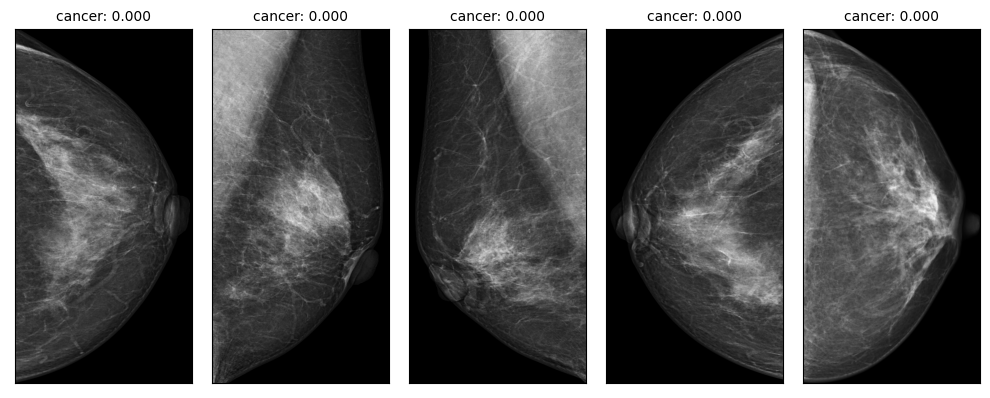

In [22]:
display_batch(batch, 5);

# Visualizing Augumented Images

Here we will be doing image agumentation for the training dataset


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


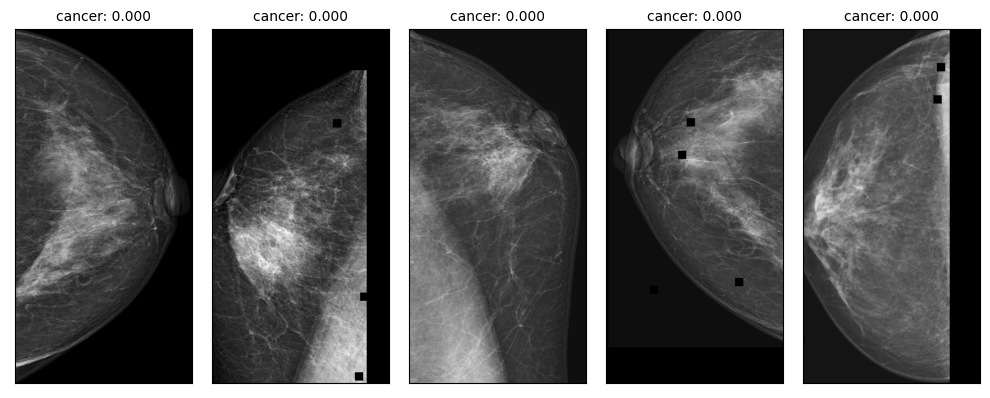

In [23]:
ds = custom_dataset(train_df["image_destination"], labels=train_df["cancer"], batch_size = CFG.batch_size, \
                    decode_fn=transform_fn, augment_fn=augumentation_fn, augment=True, repeat=False, \
                    shuffle=1024, drop_remainder=False)
ds = ds.unbatch().batch(20)
batch = next(iter(ds))
display_batch(batch, 5);

# Performance metrics

In [24]:
# tensorflow

class pFBeta(tf.keras.metrics.Metric):
    """Compute overall probabilistic F-beta score."""
    def __init__(self, beta=1, epsilon=1e-5, name='pF1', **kwargs):
        super().__init__(name=name, **kwargs)
        self.beta = beta
        self.epsilon = epsilon
        self.pos = self.add_weight(name='pos', initializer='zeros')
        self.ctp = self.add_weight(name='ctp', initializer='zeros')
        self.cfp = self.add_weight(name='cfp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 0, 1)
        pos = tf.reduce_sum(y_true)
        ctp = tf.reduce_sum(y_pred[y_true==1])
        cfp = tf.reduce_sum(y_pred[y_true==0])
        self.pos.assign_add(pos)
        self.ctp.assign_add(ctp)
        self.cfp.assign_add(cfp)

    def result(self):
        beta_squared = self.beta * self.beta
        c_precision = self.ctp / (self.ctp + self.cfp + self.epsilon)
        c_recall = self.ctp / (self.pos + self.epsilon)
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return tf.cond(c_precision > 0 and c_recall > 0, lambda: result, lambda: 0.0)


# computes batch-wise pfbeta
def pfbeta_tf(labels, preds, beta=1):
    eps = 1e-5
    preds = tf.clip_by_value(preds, 0, 1)
    y_true_count = tf.reduce_sum(labels)
    ctp = tf.reduce_sum(preds[labels==1])
    cfp = tf.reduce_sum(preds[labels==0])
    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp + eps)
    c_recall = ctp / (y_true_count + eps)
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + eps)
        return result
    else:
        return tf.constant(0.0, dtype=tf.float32)

# finds best pf1 using thresholds
def pfbeta_thr(labels, preds):
    thrs = tf.range(0, 1, 0.05)
    best_score = tf.constant(0, dtype=tf.float32)
    for thr in thrs:
        score = pfbeta_tf(labels, tf.cast(preds>thr, tf.float32))
        best_score = tf.cond(score > best_score, lambda: score, lambda: best_score)
    return best_score

pfbeta_thr.__name__='pF1_thr'


# numpy
def pfbeta(labels, preds, beta=1):
    eps = 1e-5
    preds = preds.clip(0, 1)
    y_true_count = labels.sum()
    ctp = preds[labels==1].sum()
    cfp = preds[labels==0].sum()
    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp + eps)
    c_recall = ctp / (y_true_count + eps)
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + eps)
        return result
    else:
        return 0.0

In [25]:
from keras.models import Model
from keras.layers import Dense, Input

# Build model

In [26]:
from keras_cv_attention_models import efficientnet

def build_model(model_name = CFG.model_name, loss_name=CFG.loss, \
                compile_model=True):
    pre_trained_model = getattr(efficientnet, \
                                model_name)(input_shape=(*CFG.img_size,3), \
                                            pretrained='imagenet', \
                                            num_classes=0) 
    inp = pre_trained_model.inputs
    x = pre_trained_model.output
    x =  tf.keras.layers.GlobalAveragePooling2D()(x)
    new_output = Dense(64, activation="relu") (x)
    new_output = Dense(1, activation="sigmoid")(new_output)
    # Build a new model
    model = Model(inp, new_output)
    
    if compile_model:
        # optimizer
        opt = tf.keras.optimizers.Adam(learning_rate=CFG.learning_rate)
        # loss
        if loss_name == 'BCE':
            loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1)
        elif loss_name == 'Focal':
            loss = tf.keras.losses.BinaryFocalCrossentropy(alpha=CFG.ALPHA, \
                                                           gamma=CFG.GAMMA)
        # metric
        auc = tf.keras.metrics.AUC(name='auc')
        pf1 = pFBeta(name='pF1')
        pf1_thr = pfbeta_thr
        metrics = [pf1, pf1_thr, auc]
        # compile
        model.compile(optimizer=opt,
                      loss=loss,
                      metrics=metrics)
    return model

ddsm_model = build_model(CFG.model_name)

79202800/79202800 [==============================] - 1s 0us/step
>>>> Load pretrained from: /root/.keras/models/efficientnetv2/efficientnetv1-b4-imagenet.h5


# Learning Rate Scheduler

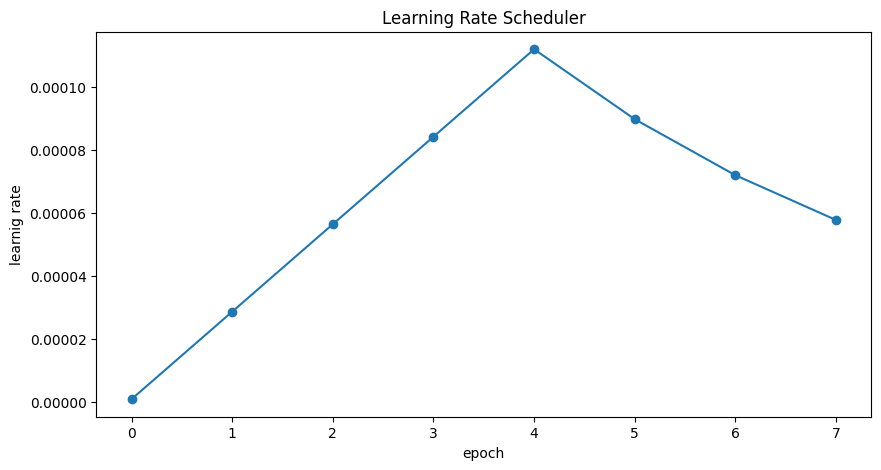

In [27]:
def get_lr_callback(batch_size=CFG.batch_size, plot=False):
    lr_start   = CFG.learning_rate
    lr_max     = CFG.lr_max * REPLICAS * (batch_size/2)
    lr_min     = CFG.min_lr
    lr_ramp_ep = 4
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        elif CFG.scheduler=='exp':
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        elif CFG.scheduler=='cosine':
            decay_total_epochs = CFG.epochs - lr_ramp_ep - lr_sus_ep + 3
            decay_epoch_index = epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            cosine_decay = 0.4 * (1 + math.cos(phase))
            lr = (lr_max - lr_min) * cosine_decay + lr_min
        return lr
    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(np.arange(CFG.epochs), [lrfn(epoch) for epoch in np.arange(CFG.epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('learnig rate')
        plt.title('Learning Rate Scheduler')
        plt.show()

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

_=get_lr_callback(CFG.batch_size, plot=True )

In [28]:
## Debug mode
# train_df = train_df.iloc[0:1000, :]
# train_df.shape

# Fit the model

In [29]:
for fold in CFG.selected_folds:
    print(f"Validation fold = {fold}")
    train = train_df[train_df["fold"]!=fold].reset_index(drop=True).copy()
    valid = train_df[train_df["fold"]==fold].reset_index(drop=True).copy()
    num_cancer_valid = valid[valid["cancer"]==1].shape[0]
    
    # upsample cancer data
    pos_df = train.query("cancer==1").sample(frac=CFG.upsample, replace=True)
    neg_df = train.query("cancer==0")
    
    train = pd.concat([pos_df, neg_df], axis=0, ignore_index=True)
    
    # get image_paths and labels
    train_paths = train.image_destination.values; train_labels = train[CFG.target_col].values.astype(np.float32)
    valid_paths = valid.image_destination.values; valid_labels = valid[CFG.target_col].values.astype(np.float32)
    
    # shuffle train data
    index = np.arange(len(train))
    np.random.shuffle(index)
    train_paths  = train_paths[index]
    train_labels = train_labels[index]
    
    print('#'*40); 
    print('#### FOLD: ',fold)
    print(f"#### Number of cancer in the Validation fold is {num_cancer_valid}")
    print('#### IMAGE_SIZE: (%i, %i) | MODEL_NAME: %s | BATCH_SIZE: %i'%
          (CFG.img_size[0],CFG.img_size[1],CFG.model_name,CFG.batch_size*REPLICAS))
    print(f"#### Number of rows in train: {len(train)}, and number of rows in val {len(valid)}")
    print('#'*40);
    
    # build model
    tf.keras.backend.clear_session()
    with strategy.scope():
        train_model = build_model(model_name = CFG.model_name)
    
    train_ds = custom_dataset(train_paths, labels=train_labels, batch_size = CFG.batch_size*REPLICAS, \
                              decode_fn=transform_fn, augment_fn=augumentation_fn, augment=True, \
                              repeat=True, shuffle=1024, drop_remainder=False)
    
    valid_ds = custom_dataset(valid_paths, labels=valid_labels, batch_size = CFG.batch_size*REPLICAS, \
                              decode_fn=transform_fn, augment_fn=None, augment=False, repeat=False, \
                              shuffle=1024, drop_remainder=False)
    
    # callbacks
    callbacks = []
    ## save best model after each fold
    sv = tf.keras.callbacks.ModelCheckpoint('efficientnetb4_P2_kaggle_fold-%i.h5'%fold, \
                                            monitor='val_pF1_thr', verbose=True, \
                                            save_best_only=True, \
                                            save_weights_only=False, mode='max', \
                                            save_freq='epoch')
    callbacks +=[sv]
    ## lr-scheduler
    callbacks += [get_lr_callback(CFG.batch_size)]
    
    print("Training the model...")
    history = train_model.fit(train_ds, epochs=CFG.epochs, callbacks = callbacks, \
                             steps_per_epoch=len(train_paths)/CFG.batch_size//REPLICAS, \
                             validation_data=valid_ds, verbose=True)
    print('#'*70);

Validation fold = 0
########################################
#### FOLD:  0
#### Number of cancer in the Validation fold is 205
#### IMAGE_SIZE: (1024, 512) | MODEL_NAME: EfficientNetV1B4 | BATCH_SIZE: 224
#### Number of rows in train: 52303, and number of rows in val 10980
########################################
>>>> Load pretrained from: /root/.keras/models/efficientnetv2/efficientnetv1-b4-imagenet.h5
Here we will be doing image agumentation for the training dataset
Training the model...
Epoch 1/8
233/233 [==============================] - ETA: 0s - loss: 0.6122 - pF1: 0.2537 - pF1_thr: 0.3564 - auc: 0.5081
Epoch 1: val_pF1_thr improved from -inf to 0.05051, saving model to efficientnetb4_P2_kaggle_fold-0.h5
233/233 [==============================] - 914s 3s/step - loss: 0.6122 - pF1: 0.2537 - pF1_thr: 0.3564 - auc: 0.5081 - val_loss: 0.5324 - val_pF1: 0.0360 - val_pF1_thr: 0.0505 - val_auc: 0.5271 - lr: 1.0000e-06
Epoch 2/8
233/233 [==============================] - ETA: 0s - loss: 